In [1]:
import os
import sys
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import matplotlib.ticker as mtick
from importlib import reload
from statsmodels.stats.proportion import proportions_ztest
from statsmodels.stats.multitest import multipletests
from scipy.interpolate import make_interp_spline
# import minimum_detectable_effect_size as mdes
from time import gmtime, strftime
from tqdm import tqdm
from matplotlib import style


sys.path.append('../utils/') 

# from ..utils.standalone_functions import make_mde_plot
import standalone_functions as sf

pd.options.display.max_columns=500
pd.options.display.max_colwidth=500
pd.options.display.max_rows=500

warnings.filterwarnings('ignore')

# set the plot style
style.use('fivethirtyeight')
# %matplotlib inline

# sys.path.append('../../ab_testing_utils/') 


# questions for dan
# why "query" instead of normal filtering?
# why the underscore after some variable names?
# why put it all in a class, and how do you determine the ordering of functions / methods / objects in a class?
# what is a @staticmethod?\
# this is all frequentist right? how might we incorporate priors?
# explain the fake data generation
# historical_success_rate_dict is confusing / sketchy?
# which type of t test is this? and what about a prop test?
# can you show examples of all this in action? 

# aggregate, plot, prop, bayes


In [2]:
reload(sf)

<module 'standalone_functions' from '/Users/dbendet/code/data_notes/notebooks/../utils/standalone_functions.py'>

In [3]:
generate_fake_data = False

In [4]:
from pydataset import data
from kaggle.api.kaggle_api_extended import KaggleApi

In [5]:
# from kaggle
api = KaggleApi()
api.authenticate()
api.competitions_list(category='gettingStarted')
# or ‘all’, ‘featured’, ‘research’, ‘recruitment’, ‘gettingStarted’, ‘masters’, ‘playground’

# grabbing data
api.competition_list_files('house-prices-advanced-regression-techniques')
api.competition_download_files('house-prices-advanced-regression-techniques')
from zipfile import ZipFile
zf = ZipFile('house-prices-advanced-regression-techniques.zip')
zf.extractall('data')
zf.close()

! cd data && ls

data_description.txt  test.csv
sample_submission.csv train.csv


In [6]:
# defining data variables
sample_submission = pd.read_csv('data/sample_submission.csv')
test = pd.read_csv('data/test.csv')
train = pd.read_csv('data/train.csv')

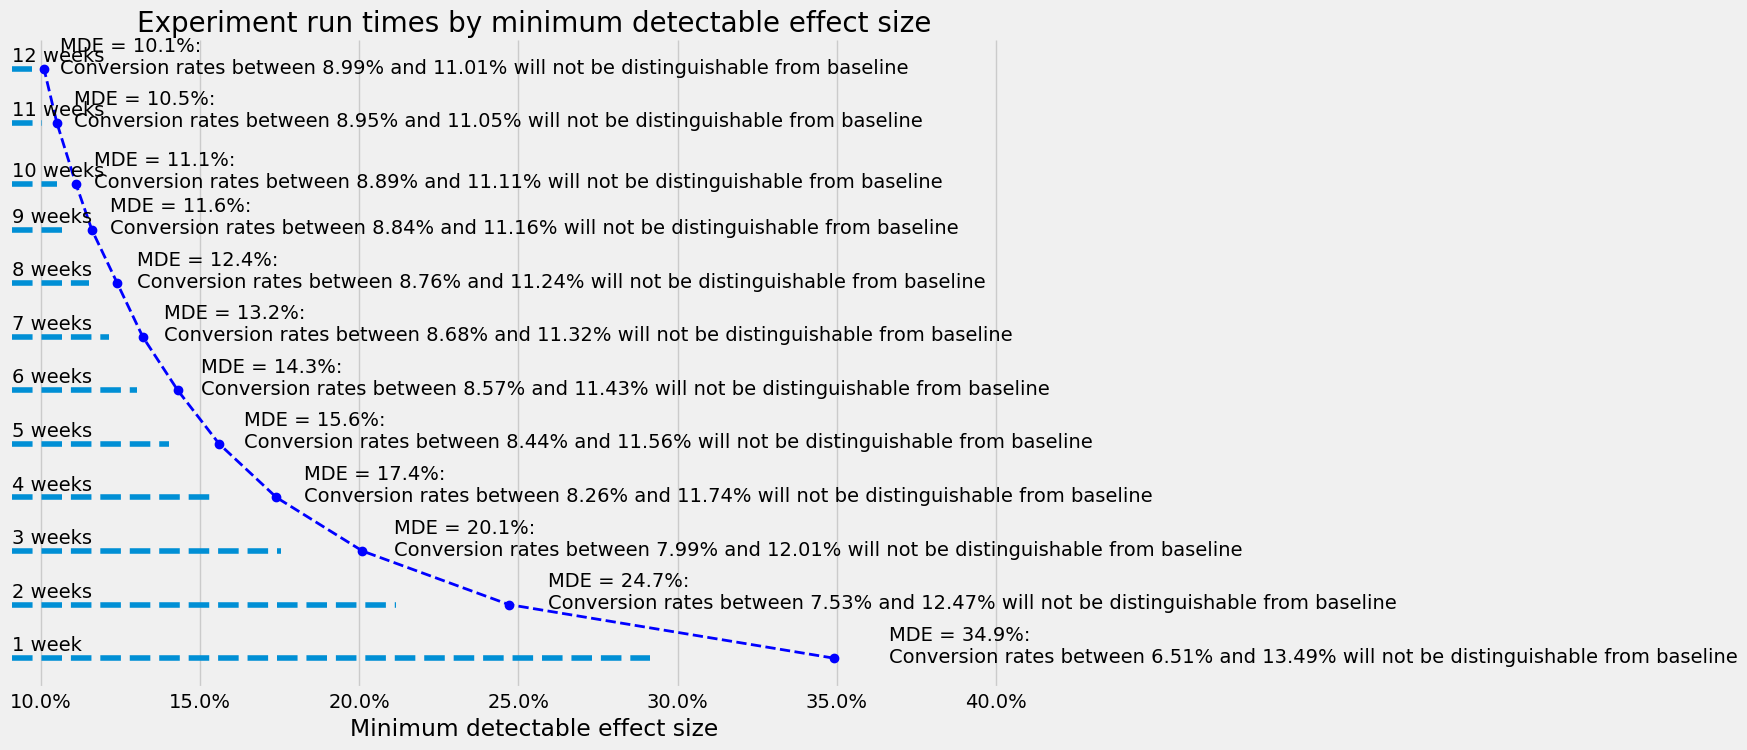

In [7]:
# plotting power calc estimates for theoretical run times

ab_test_sample = train[train.YrSold.isin([2008,2009])]
ab_test_sample['YrSold'] = ab_test_sample['YrSold'].astype(str)
ab_test_sample = ab_test_sample[['YrSold', 'SalePrice']]
# ab_test_sample

df_mde = sf.create_mde_table(monthly_num_obs=10000, baseline_conversion_rate=0.1, alpha=0.05, power=0.8)
# df_mde

sf.make_mde_plot(df_ = df_mde,
              min_weeks = 1, 
              max_weeks =  12, 
              save_path = None, 
              output_filename = None, 
              conservative_runtime = False, 
              figsize = (12, 8))


In [8]:

# running ab test

ab_test_sample = train[train.YrSold.isin([2008,2009])]
ab_test_sample['YrSold'] = ab_test_sample['YrSold'].astype(str)
ab_test_sample = ab_test_sample[['YrSold', 'SalePrice']]
# ab_test_sample

experiment_results = sf.simple_ab_test(self = False, 
                                    df=ab_test_sample, 
                                    group_column_name = 'YrSold', 
                                    treatment_name = '2009', 
                                    outcome_column = 'SalePrice', 
                                    alpha = 0.05, 
                                    null_hypothesis = 0.0)
print(experiment_results)
print('---------------------------------------')
print("""The treatment is {0} percent different from the control. The p-value is {1}. The control group had a sample size of {2}
and the treatment group had a sample size of {3}. The control mean was {4} vs a treatment mean of {5}. 
""".format(experiment_results['pct_change'][0],
           experiment_results['p_value'][0],
           experiment_results['count_control'][0],
           experiment_results['count_treatment'][0],
           experiment_results['control_mean'][0],
           experiment_results['treatment_mean'][0]))
# experiment_results['treatment_minus_control_mean'] / experiment_results['control_mean'][0] #pct lift
# experiment_results['p_value'][0]
# experiment_results['control_mean'][0]
# experiment_results['2009_mean'][0]


        treatment_mean  treatment_confidence_interval_95.0_percent_lower  \
YrSold                                                                     
2009               NaN                                     170809.730912   

        treatment__confidence_interval_95.0_percent_upper   control_mean  \
YrSold                                                                     
2009                                        188054.476189  177360.838816   

        control_confidence_interval_95.0_percent_lower  \
YrSold                                                   
2009                                       -9581.92001   

        control_confidence_interval_95.0_percent_upper  \
YrSold                                                   
2009                                      13724.449479   

        treatment_minus_control_mean  count_control  count_treatment  \
YrSold                                                                 
2009                     2071.264735          30

In [9]:
# grabbing summary stats from above as if we already had them aggregated and running ab test

experiment_results_agg = sf.simple_ab_test_aggregate(self = False,  mu_treatment = 175289, 
                                        mu_control = 177360,
                                        std_treatment = 80879,
                                        std_control = 69735,
                                        count_treatment = 338.0,
                                        count_control = 304.0,
                                        alpha = 0.05, 
                                        null_hypothesis = 0.0)

# experiment_results_agg

print(experiment_results_agg)
print('---------------------------------------')
print("""The treatment is {0} percent different from the control. The p-value is {1}. The control group had a sample size of {2}
and the treatment group had a sample size of {3}. The control mean was {4} vs a treatment mean of {5}. 
""".format(experiment_results['pct_change'][0],
           experiment_results['p_value'][0],
           experiment_results['count_control'][0],
           experiment_results['count_treatment'][0],
           experiment_results['control_mean'][0],
           experiment_results['treatment_mean'][0]))

   placeholder_col  treatment_mean  \
0                5          175289   

   treatment_confidence_interval_95.0_percent_lower  \
0                                     166666.652661   

   treatment__confidence_interval_95.0_percent_upper  control_mean  \
0                                      183911.347339        177360   

   control_confidence_interval_95.0_percent_lower  \
0                                   -13724.119846   

   control_confidence_interval_95.0_percent_upper  \
0                                     9582.119846   

   treatment_minus_control_mean  count_control  count_treatment  std_control  \
0                         -2071          304.0            338.0        304.0   

   std_treatment  z_statistic   p_value  pct_change  
0          338.0    -0.348326  0.363798   -0.011677  
---------------------------------------
The treatment is 0.011678252924015885 percent different from the control. The p-value is 0.6362183297431623. The control group had a sample size of 

In [10]:
# same thing but using dan's module

import conversion_rate_utils
# reload(conversion_rate_utils)

ab_test_sample = train[train.YrSold.isin([2008,2009])]
ab_test_sample['YrSold'] = ab_test_sample['YrSold'].astype(str)
ab_test_sample = ab_test_sample[['YrSold', 'SalePrice']]
# ab_test_sample


test_experiment = conversion_rate_utils.ConversionExperiment()

experiment_results = test_experiment.simple_ab_test(
                                                    df=ab_test_sample, 
                                                    group_column_name = 'YrSold', 
                                                    treatment_name = '2009', 
                                                    outcome_column = 'SalePrice', 
                                                    alpha = 0.05, 
                                                    null_hypothesis = 0.0)

print(experiment_results)
print('---------------------------------------')
print("""The treatment is {0} percent different from the control. The p-value is {1}. The control group had a sample size of {2}
and the treatment group had a sample size of {3}. The control mean was {4} vs a treatment mean of {5}. 
""".format(
           'blah', # experiment_results['pct_change'][0],
           experiment_results['p_value'][0],
           'blah', # experiment_results['count_control'][0],
           'blah', # experiment_results['count_treatment'][0],
           experiment_results['control_mean'][0],
           experiment_results['treatment_mean'][0]))
# experiment_results['treatment_minus_control_mean'] / experiment_results['control_mean'][0] #pct lift
# experiment_results['p_value'][0]
# experiment_results['control_mean'][0]
# experiment_results['2009_mean'][0]


        treatment_mean  treatment_confidence_interval_95.0_percent_lower  \
YrSold                                                                     
2009               NaN                                     170809.730912   

        treatment__confidence_interval_95.0_percent_upper   control_mean  \
YrSold                                                                     
2009                                        188054.476189  177360.838816   

        control_confidence_interval_95.0_percent_lower  \
YrSold                                                   
2009                                       -9581.92001   

        control_confidence_interval_95.0_percent_upper  \
YrSold                                                   
2009                                      13724.449479   

        treatment_minus_control_mean  z_statistic   p_value  
YrSold                                                       
2009                     2071.264735     0.348369  0.636218  
------

In [11]:
df_mde = test_experiment.create_mde_table(monthly_num_obs=10000, baseline_conversion_rate=0.1, alpha=0.05, power=0.8)
df_mde.head()

,mde,new_conversion_rate_upper_bound,new_conversion_rate_lower_bound,total_sample_size,sample_size_per_variant,days,weeks,weeks_non_rounded,fraction_of_expected_monthly_sample,monthly_additional_conversions_upper,monthly_additional_conversions_lower
0,0.001,0.1001,0.0999,282559670,141279835,847680,121098,121097.001429,28255.9670,1,-1
1,0.002,0.1002,0.0998,70639918,35319959,211920,30275,30274.250571,7063.9918,2,-2
2,0.003,0.1003,0.0997,31395518,15697759,94187,13456,13455.222000,3139.5518,3,-3
3,0.004,0.1004,0.0996,17659980,8829990,52980,7569,7568.562857,1765.9980,4,-4
4,0.005,0.1005,0.0995,11302386,5651193,33908,4844,4843.879714,1130.2386,5,-5


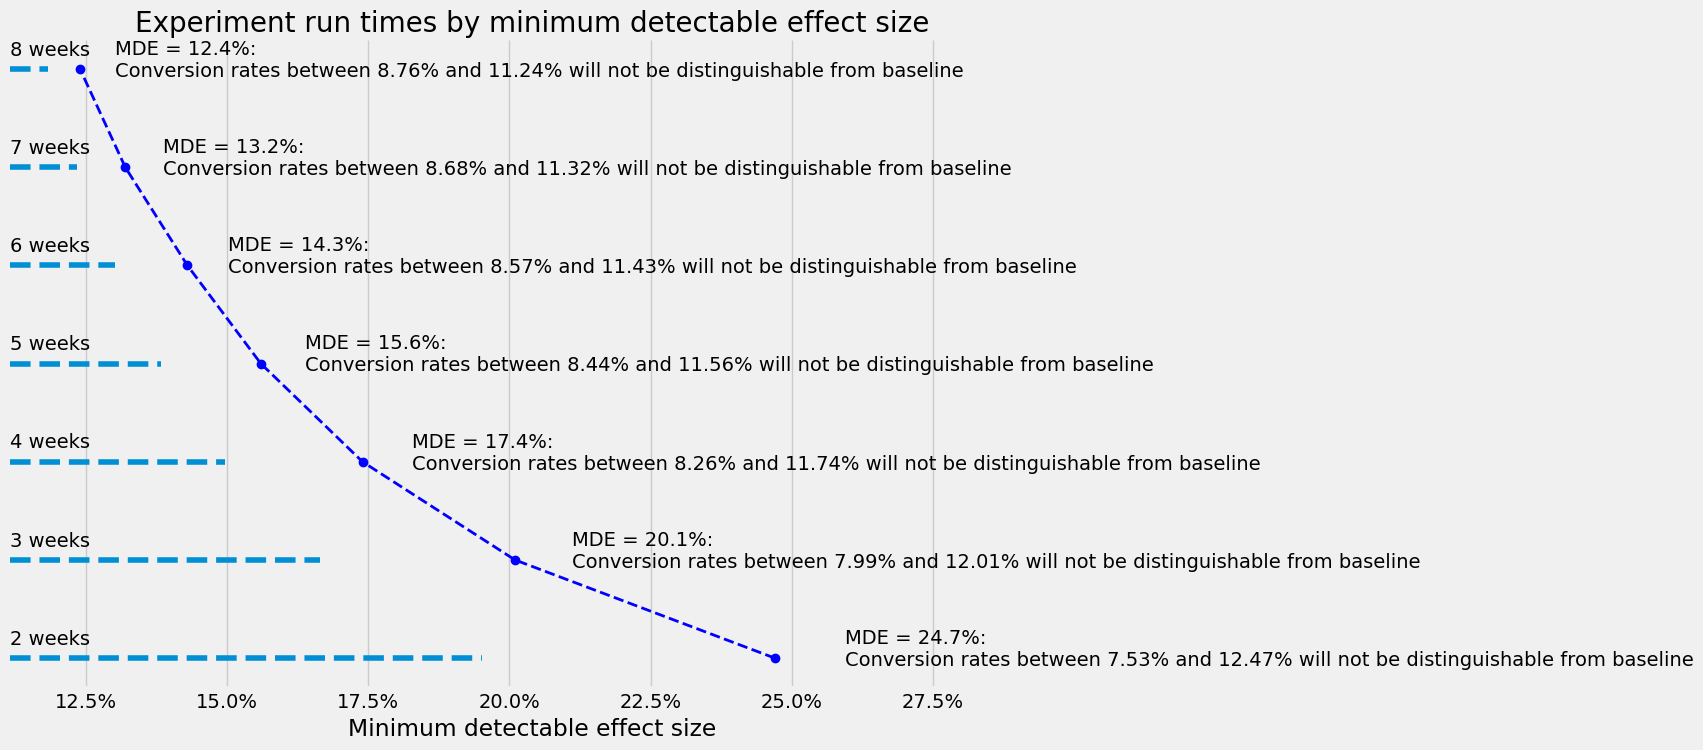

In [12]:
test_experiment.make_mde_plot(df_=df_mde, min_weeks=2, max_weeks=8)

In [13]:
# same things as above but using dan's module and fake aggregate data
import conversion_rate_utils
# reload(conversion_rate_utils)

In [14]:
test_experiment = conversion_rate_utils.ConversionExperiment()

monthly_num_observations = 30000
baseline_conversion_rate = 0.1
n_variants = 2
alpha = 0.05
power = 0.8

In [15]:
df_mde = test_experiment.create_mde_table(monthly_num_obs=monthly_num_observations, baseline_conversion_rate=baseline_conversion_rate, alpha=alpha, power=power)
df_mde.head()

,mde,new_conversion_rate_upper_bound,new_conversion_rate_lower_bound,total_sample_size,sample_size_per_variant,days,weeks,weeks_non_rounded,fraction_of_expected_monthly_sample,monthly_additional_conversions_upper,monthly_additional_conversions_lower
0,0.001,0.1001,0.0999,282559670,141279835,282560,40366,40365.667143,9418.655667,3,-3
1,0.002,0.1002,0.0998,70639918,35319959,70640,10092,10091.416857,2354.663933,6,-6
2,0.003,0.1003,0.0997,31395518,15697759,31396,4486,4485.074000,1046.517267,9,-9
3,0.004,0.1004,0.0996,17659980,8829990,17660,2523,2522.854286,588.666000,12,-12
4,0.005,0.1005,0.0995,11302386,5651193,11303,1615,1614.626571,376.746200,15,-15


In [16]:
df_mde.query('mde == 0.05')

,mde,new_conversion_rate_upper_bound,new_conversion_rate_lower_bound,total_sample_size,sample_size_per_variant,days,weeks,weeks_non_rounded,fraction_of_expected_monthly_sample,monthly_additional_conversions_upper,monthly_additional_conversions_lower
49,0.05,0.105,0.095,113024,56512,114,17,16.146286,3.767467,150,-150


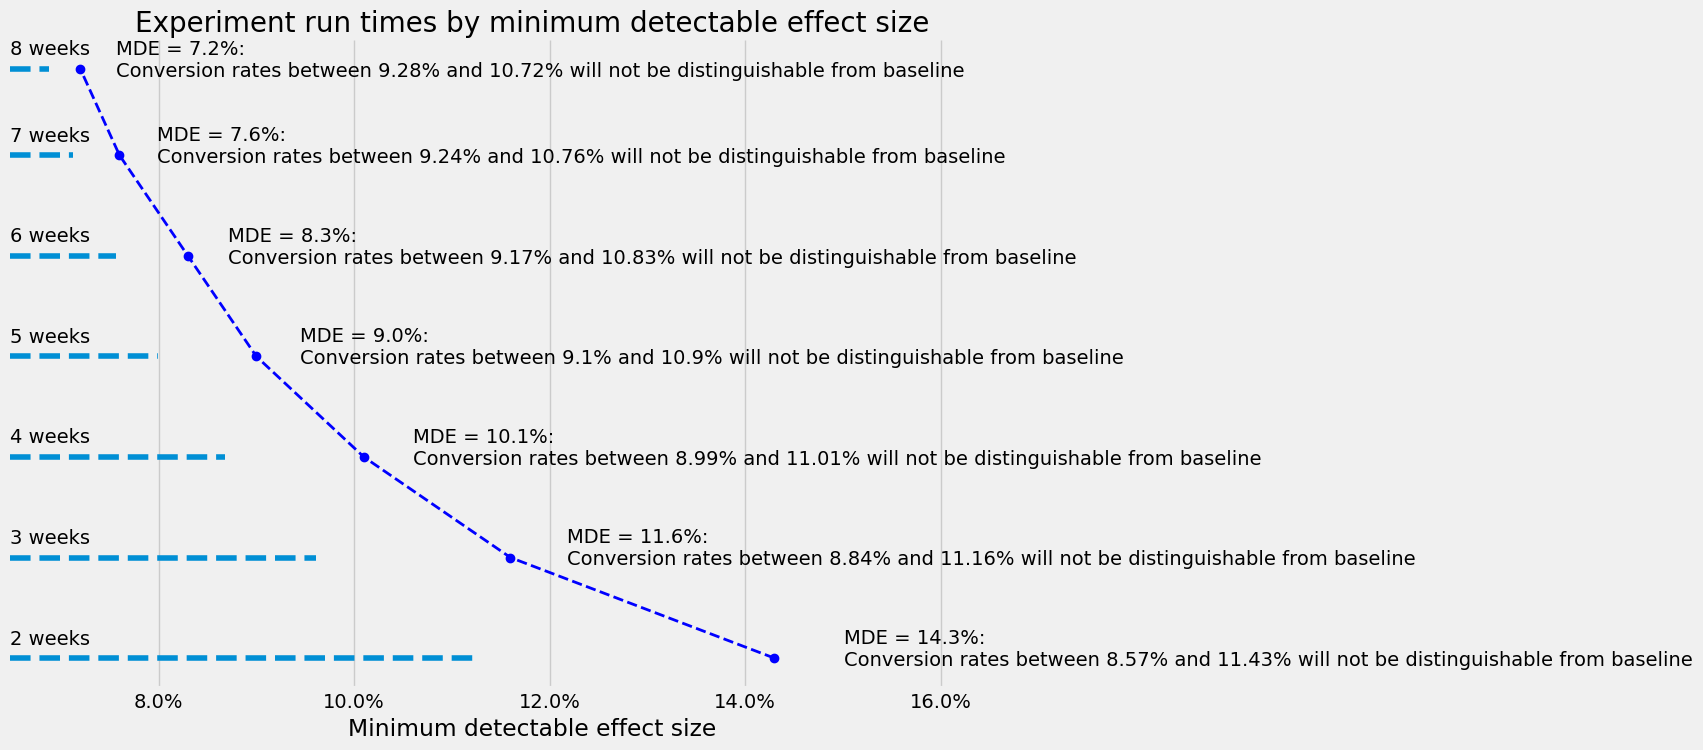

In [17]:
test_experiment.make_mde_plot(df_=df_mde, min_weeks=2, max_weeks=8)

In [18]:
# prop test with fake data
sample_sizes = [138538, 138517, 137562, 138475]
conversions = [130, 162, 169, 164]

not_conversions = [x - y for (x, y) in zip(sample_sizes, conversions)]
contigency = [(x, y) for x, y in zip(conversions, not_conversions)]
T = np.array(contigency)

In [19]:
stats.chi2_contingency(T, correction=True)

Chi2ContingencyResult(statistic=6.244363060071456, pvalue=0.10030814068159973, dof=3, expected_freq=array([[   156.54945289, 138381.45054711],
       [   156.52572266, 138360.47427734],
       [   155.44656224, 137406.55343776],
       [   156.47826221, 138318.52173779]]))

In [20]:
stats.chi2_contingency(T, correction=False)

Chi2ContingencyResult(statistic=6.244363060071456, pvalue=0.10030814068159973, dof=3, expected_freq=array([[   156.54945289, 138381.45054711],
       [   156.52572266, 138360.47427734],
       [   155.44656224, 137406.55343776],
       [   156.47826221, 138318.52173779]]))

In [21]:
p_c_vs_v2 = proportions_ztest(count=[conversions[0], conversions[1]], nobs=[sample_sizes[0], sample_sizes[1]], alternative='two-sided')[1]
p_c_vs_v3 = proportions_ztest(count=[conversions[0], conversions[2]], nobs=[sample_sizes[0], sample_sizes[2]], alternative='two-sided')[1]
p_c_vs_v4 = proportions_ztest(count=[conversions[0], conversions[3]], nobs=[sample_sizes[0], sample_sizes[3]], alternative='two-sided')[1]
p_v2_vs_v3 = proportions_ztest(count=[conversions[1], conversions[2]], nobs=[sample_sizes[1], sample_sizes[2]], alternative='two-sided')[1]
p_v2_vs_v4 = proportions_ztest(count=[conversions[1], conversions[3]], nobs=[sample_sizes[1], sample_sizes[3]], alternative='two-sided')[1]
p_v3_vs_v4 = proportions_ztest(count=[conversions[2], conversions[3]], nobs=[sample_sizes[2], sample_sizes[3]], alternative='two-sided')[1]

In [22]:
multipletests(pvals=[p_c_vs_v2, p_c_vs_v3, p_c_vs_v4, p_v2_vs_v3, p_v2_vs_v4, p_v3_vs_v4], method='bonferroni')


(array([False, False, False, False, False, False]),
 array([0.36480431, 0.12275362, 0.28095308, 1.        , 1.        ,
        1.        ]),
 0.008512444610847103,
 0.008333333333333333)

In [23]:
# None of these are statistically significant 
